In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np 
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from keras.layers import Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import time

In [2]:
# 2. Load data
train_dir = "../input/gender-dataset/Dataset/Train/"
val_dir = "../input/gender-dataset/Dataset/Validation/"
test_dir = "../input/gender-dataset/Dataset/Test/"

CATEGORIES = ["FeMale", "Male"]

img_width = 64
img_height = 64
img_channel = 3

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(val_dir, target_size=(img_width, img_height), 
                                                     subset='training', batch_size=64, class_mode='categorical')
val_generator = data_generator.flow_from_directory(val_dir, target_size=(img_width, img_height), 
                                                   subset='validation', batch_size=64, class_mode='categorical')
test_generator = data_generator.flow_from_directory(test_dir, target_size=(img_width, img_height), 
                                                    batch_size=64, class_mode='categorical')

Found 18079 images belonging to 2 classes.
Found 4519 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


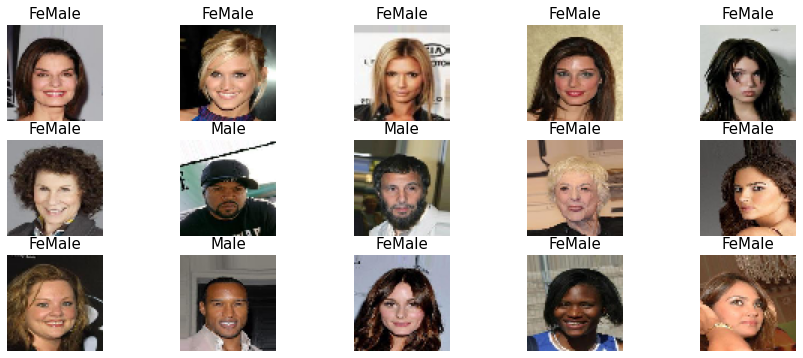

In [3]:
# 3. Show image
img, label = val_generator.next()
label = np.argmax(label, 1)
rows = 3
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[label[i]], fontsize=15)

In [4]:
# 4. Build model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, img_channel)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2022-08-03 13:38:06.740150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:06.895067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:06.895811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:06.896978: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

node zero
2022-08-03 13:38:06.897984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:06.898607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:09.302437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:09.303334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 13:38:09.304168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [5]:
# 5. Train model
start_time = time.time()

numOfEpoch = 15
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2,
                                            verbose = 1,factor = 0.5,min_lr = 0.00001)
model_checkpoint = ModelCheckpoint(filepath='../input/model.h5', monitor='val_acc', mode='max', save_best_only=True)

H =  model.fit(train_generator, epochs = numOfEpoch, validation_data = val_generator, 
               verbose=1, callbacks=[earlystop, learning_rate_reduction, model_checkpoint])

end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

2022-08-03 13:38:10.218315: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-08-03 13:38:12.231008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


283/283 [==============================] - 95s 309ms/step - loss: 0.5073 - accuracy: 0.7937 - val_loss: 1.2691 - val_accuracy: 0.6103
Epoch 2/15
283/283 [==============================] - 33s 118ms/step - loss: 0.2086 - accuracy: 0.9152 - val_loss: 0.1847 - val_accuracy: 0.9301
Epoch 3/15
283/283 [==============================] - 33s 118ms/step - loss: 0.1659 - accuracy: 0.9353 - val_loss: 0.1423 - val_accuracy: 0.9449
Epoch 4/15
283/283 [==============================] - 33s 116ms/step - loss: 0.1360 - accuracy: 0.9475 - val_loss: 0.1133 - val_accuracy: 0.9526
Epoch 5/15
283/283 [==============================] - 34s 119ms/step - loss: 0.1231 - accuracy: 0.9520 - val_loss: 0.1094 - val_accuracy: 0.9551
Epoch 6/15
283/283 [==============================] - 33s 118ms/step - loss: 0.1107 - accuracy: 0.9587 - val_loss: 0.1630 - val_accuracy: 0.9305
Epoch 7/15
283/283 [==============================] - 33s 116ms/step - loss: 0.1002 - accuracy: 0.9607 - val_loss: 0.1372 - val_accuracy: 0.9

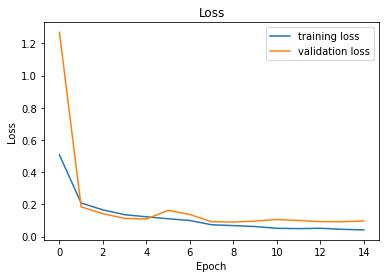

In [6]:
# 6. Vẽ đồ thị loss của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['loss'], label='training loss')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

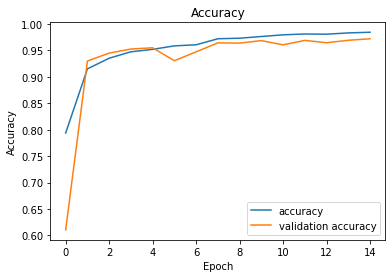

In [7]:
# 7. Vẽ đồ thị accuracy của traning set và validation set
plt.plot(np.arange(0, len(H.epoch)), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, len(H.epoch)), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
# 8. Đánh giá model với testset
start_time = time.time()
print('[loss, accuracy]: ', model.evaluate(test_generator, verbose = 1))
end_time = time.time()
print("Running time: %.2f (s)" % (end_time - start_time))

313/313 [==============================] - 77s 248ms/step - loss: 0.0922 - accuracy: 0.9725
[loss, accuracy]:  [0.09221559762954712, 0.972451388835907]
Running time: 82.20 (s)


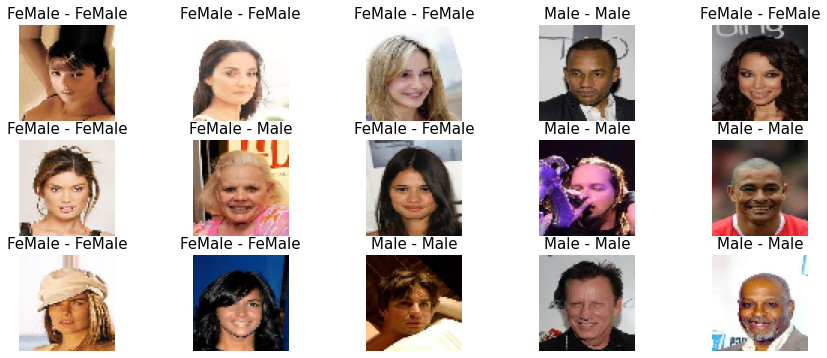

In [9]:
# 9. Show predict on tesetset
img, label = test_generator.next()
label = np.argmax(label, 1)
rows = 3
cols = 5

pred = model.predict(img[0: rows * cols])
pred = np.argmax(pred, 1)

fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(img[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[pred[i]] + ' - ' + CATEGORIES[label[i]], fontsize=15)

In [10]:
# 10. Save model
model.save("Gender_Classification_Model.h5")

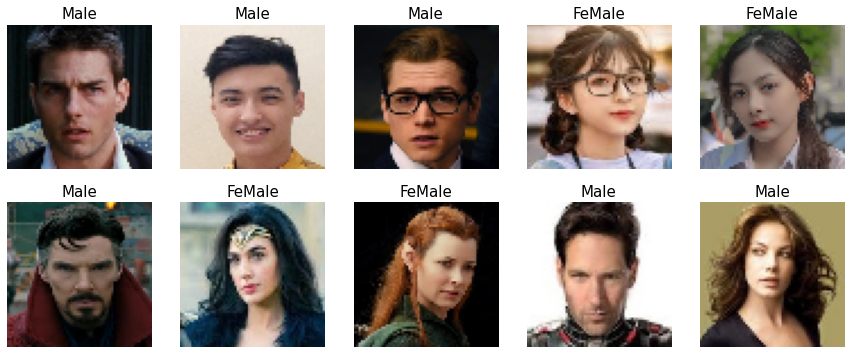

In [11]:
# 11. Test
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os


dir_path = '../input/image-test/'
imgs = []
for name in os.listdir(dir_path):
    img = cv2.imread(dir_path + name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(src=img, dsize=(64, 64))/255.0
  
    imgs.append(img)

imgs = np.array(imgs)
pred = np.argmax(model.predict(imgs), 1)

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15,6))
axes = axes.ravel()
for i in range(rows*cols):
    axes[i].imshow(imgs[i])
    axes[i].axis('off')
    axes[i].set_title(CATEGORIES[pred[i]], fontsize=15)